<a href="https://colab.research.google.com/github/RajeshNN/neural-style-transfer/blob/main/Neural_Style_Transfer_and_Color_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Style Transfer using pretrained Torchvision model with color transfer...

### Importing libraries...

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import requests
from scipy import linalg as LG
from skimage.color import rgb2yiq, yiq2rgb

%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

In [3]:
from torchvision.models import vgg
import torchvision.transforms as transforms

### Preparing content and style images...

In [4]:
img = Image.open(requests.get("https://media1.s-nbcnews.com/j/newscms/2020_42/3419312/201012-gal-gadot-mc-1221_212dac7f3c5f52bf68273830d965ed84.fit-760w.JPG", stream = True).raw)
img2 = Image.open(requests.get("https://miro.medium.com/max/6976/1*RSyYDJNqbMEZfe7khWnJ6A.jpeg", stream = True).raw)

In [5]:
def prep_img(img, size = (400,300)):
  return np.asarray(img.resize(size, Image.ANTIALIAS))

In [6]:
content_image = prep_img(img)
style_image = prep_img(img2)

(-0.5, 399.5, 299.5, -0.5)

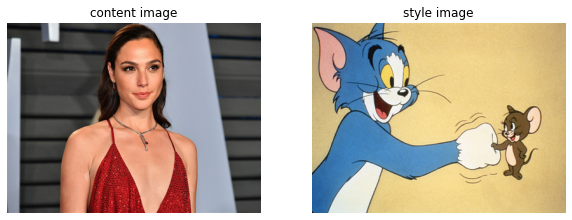

In [7]:
fig, ax = plt.subplots(1, 2, figsize = (10,10))
ax[0].axis('off')
ax[0].imshow(content_image)
ax[0].set_title('content image')
ax[1].imshow(style_image)
ax[1].set_title('style image')
ax[1].axis('off')

### Some useful constants...

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [9]:
STYLE_LAYERS = [
                (3, 'conv1_2', 0.2),
                (8, 'conv2_2', 0.2),
                (13, 'conv3_2', 0.2),
                (22, 'conv4_2', 0.2),
                (31, 'conv5_2', 0.2),
                ]

CONTENT_LAYER = [(29, 'conv5_1', 1.0)]

activation = {}

### Defining some useful functions...

In [10]:
# converts numpy array of shape (..., 3) or (3, ...) to torch.Tensor of shape torch.Size([1, 3, ...])
def img_to_tensor(img, device = 'cpu'):
  if img.shape[2]==3:
    img = img.transpose(2,0,1)
  tensor = torch.from_numpy(img).type(torch.FloatTensor)
  tensor = tensor.unsqueeze(0).to(device)
  return tensor

In [11]:
# converts torch.Tensor of shape torch.Size([1, 3, ...]) to numpy array of shape (..., 3)
def tensor_to_img(tensor):
  return tensor.squeeze(0).detach().cpu().numpy().transpose(1,2,0).astype('uint8')

### Defining the *pretrained* torchvision model...

In [12]:
model = vgg.vgg19(pretrained = True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [13]:
model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

### functions to get activations from different layers of the model...

In [14]:
def get_activation(layer):
    def hook(model, input, output):
        activation[layer] = output.detach()   #note use of .detach() to remove the variable out of backpropagation graph
    return hook                               #these set of activations remain constant while generation of image

def get_activation_(layer):
    def hook(model, input, output):
        activation[layer] = output
    return hook

### functions for neural style transfer...

In [15]:
def Compute_Content_Cost(content_activation, input):
  return F.mse_loss(input, content_activation)

In [16]:
def gram_matrix(A):
  a, b, c, d = A.shape
  f = A.view(a * b, c * d)
  GA = torch.mm(f, f.t())
  return GA.div(a * b * c * d)

In [17]:
def Compute_Style_Cost(style_activations, input_activations, STYLE_LAYERS = STYLE_LAYERS):
  J_style = 0
  for layer, layer_name, coeff in STYLE_LAYERS:
    style_matrix = gram_matrix(style_activations[layer])
    J_style += coeff * (F.mse_loss(gram_matrix(input_activations[layer]), style_matrix)).to(device)
  return J_style

### functions for different color transfer techniques...

#### color histogram matching...

In [18]:
# calculates channel means covariance matrix for image of shape (..., 3) or (3, ...)
def musigma(arr):
  if arr.shape[2] == 3:
    arr = arr.transpose(2, 0, 1)
  narr = arr.reshape(3, -1)
  mu = (narr.sum(axis = 1)/narr.shape[1]).reshape(-1,1)
  sigma = np.matmul((narr - mu), (narr - mu).T) / narr.shape[1]
  return mu, sigma

In [19]:
# calculates transformation matrices for color histogram matching using Cholesky decomposition
def cholesky(carr,sarr):
  cmu, csig = musigma(carr)
  smu, ssig = musigma(sarr)
  A_chol = np.matmul(np.linalg.cholesky(csig), np.linalg.inv(np.linalg.cholesky(ssig)))
  b_chol = cmu - np.matmul(A_chol,smu)
  return A_chol, b_chol

In [20]:
# calculates transformation matrices for color histogram matching using 3D color matching formulations
def image_analogies(carr, sarr):
  cmu, csig = musigma(carr)
  smu, ssig = musigma(sarr)
  A = np.matmul(LG.fractional_matrix_power(csig,0.5), LG.fractional_matrix_power(ssig,-0.5))
  b = cmu - np.matmul(A, smu)
  return A, b

In [21]:
# updates style image using color histogram matching
def style_img_transform(carr, sarr, method = 'image_analogies'):
  if carr.shape[2] == 3:
    carr = carr.transpose(2,0,1)
  if sarr.shape[2] == 3:
    sarr = sarr.transpose(2,0,1)
  if method == 'image_analogies':
    A, b = image_analogies(carr, sarr)
  elif method == 'cholesky':
    A, b = cholesky(carr,sarr)
  
  ss = sarr.reshape(3,-1)
  n_ss = np.matmul(A, ss) + b
  n_ss = n_ss.reshape(sarr.shape)
  return n_ss.transpose(1,2,0)

#### luminance-only transfer

In [22]:
def sRGBtoLum(colorChannel):
  # Send this function a decimal sRGB gamma encoded color value
  # between 0.0 and 1.0, and it returns a linearized value.
  if ( colorChannel <= 0.04045 ):
    return colorChannel / 12.92
  else:
    return (( colorChannel + 0.055)/1.055)**2.4

In [23]:
# extracts luminance channel from image of shape (..., 3) or (3, ...)
def lum(arr):
  if arr.shape[2] == 3:
    arr = arr.transpose(2, 0, 1)
  L = np.zeros((arr.shape[1], arr.shape[2]))
  for i in range(arr.shape[1]):
    for j in range(arr.shape[2]):
      vR = arr[0][i][j] / 255
      vG = arr[1][i][j] / 255
      vB = arr[2][i][j] / 255
      L[i][j] = 0.2126 * sRGBtoLum(vR) + 0.7152 * sRGBtoLum(vG) + 0.0722 * sRGBtoLum(vB)

  return L

### Extracting relevant activation layers for content cost and style cost evaluation and visualizing some of them...

In [24]:
for layer, _, _ in CONTENT_LAYER:
  model[layer].register_forward_hook(get_activation(layer))
content_out = model(img_to_tensor(prep_img(img), device))
a_C = activation[CONTENT_LAYER[0][0]]
activation.clear()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  """


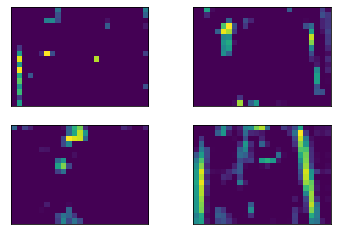

In [25]:
square = 2
ix = 1
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(a_C.cpu()[0,ix+40,:,:])
        ix += 1


In [26]:
for layer, _, _ in STYLE_LAYERS:
  model[layer].register_forward_hook(get_activation(layer))
style_out = model(img_to_tensor(prep_img(img2), device))
style_activations = activation.copy()
activation.clear()

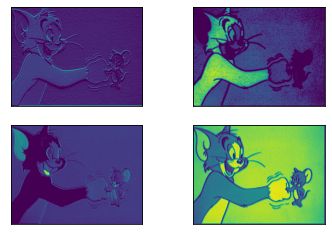

In [27]:
square = 2
ix = 1
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(style_activations[3][0,ix-1,:,:].cpu())
        ix += 1


### Defining initial image to train...

In [28]:
# returns either a noise tensor of the shape of inp_img or inp_img as the tensor
def create_input_img(inp_img, switch = None):
  if not switch:
    return (255 * torch.rand(img_to_tensor(inp_img).shape, device= device)).requires_grad_()
  else:
    return img_to_tensor(inp_img, device).requires_grad_(True)

### Putting everything together...

In [29]:
def style_transfer(cont_img, stl_img, switch = None,
                   alpha = 10, beta = 40, num_iter = 100, lr = 2.0,
                   color_transfer = True, color_transfer_method = 'luminance'):
  content_image = cont_img.copy()
  style_image = stl_img.copy()
  if color_transfer:
    if color_transfer_method == 'luminance':
      content_yiq = rgb2yiq(content_image)
    elif color_transfer_method in ['cholesky', 'image_analogies']:
      style_image = style_img_transform(content_image, style_image, method = color_transfer_method)
    else:
      raise Exception("color_transfer_method not identified! Must be one of 'luminance', 'cholesky' and 'image_analogies'.")

  content_t = img_to_tensor(content_image, device = device)
  style_t = img_to_tensor(style_image, device = device)
  
  for layer, _, _ in CONTENT_LAYER:
    model[layer].register_forward_hook(get_activation(layer))
  content_out = model(content_t)
  content_ac = activation[CONTENT_LAYER[0][0]]
  activation.clear()

  for layer, _, _ in STYLE_LAYERS:
    model[layer].register_forward_hook(get_activation(layer))
  style_out = model(style_t)
  style_ac = activation.copy()
  activation.clear()

  input_image = create_input_img(content_image, switch)
  optimizer = optim.Adam([input_image], lr = lr)

  for i in range(num_iter):
    input_image.data.clamp_(0,255)
    activation.clear()
    for layer, _, _ in STYLE_LAYERS + CONTENT_LAYER:
      model[layer].register_forward_hook(get_activation_(layer))
    out = model(input_image)

    optimizer.zero_grad()
  
    J_style = Compute_Style_Cost(style_ac, activation)
    J_content = Compute_Content_Cost(content_ac, activation[CONTENT_LAYER[0][0]])
    loss = (J_content * alpha) + (J_style * beta)
    loss.backward()
    optimizer.step()
  
  # Print every 50 iteration.
    if i%100 == 0:
      print("Iteration " + str(i) + " :")
      print("total cost = " + str(loss))
      print("content cost = " + str(J_content))
      print("style cost = " + str(J_style))

  input_image.data.clamp_(0,255)

  generated_image = tensor_to_img(input_image)

  if color_transfer and color_transfer_method == 'luminance':
    g = lum(generated_image)
    content_yiq[...,0] = g
    return yiq2rgb(content_yiq)
  
  return generated_image

In [30]:
gen0 = style_transfer(content_image, style_image, switch = 1,
                     alpha = 10, beta = 40, num_iter = 301,
                     color_transfer = False)
gen1 = style_transfer(content_image, style_image, switch = 1,
                     alpha = 10, beta = 40, num_iter = 301,
                     color_transfer = True, color_transfer_method = 'luminance')
gen2 = style_transfer(content_image, style_image, switch = 1,
                     alpha = 10, beta = 40, num_iter = 301, lr = 1.0,
                     color_transfer = True, color_transfer_method = 'cholesky')
gen3 = style_transfer(content_image, style_image, switch = 1,
                     alpha = 10, beta = 40, num_iter = 301, lr = 1.0,
                     color_transfer = True, color_transfer_method = 'image_analogies')

Iteration 0 :
total cost = tensor(378341.2500, device='cuda:0', grad_fn=<AddBackward0>)
content cost = tensor(0., device='cuda:0', grad_fn=<MseLossBackward>)
style cost = tensor(9458.5312, device='cuda:0', grad_fn=<AddBackward0>)
Iteration 100 :
total cost = tensor(9368.5117, device='cuda:0', grad_fn=<AddBackward0>)
content cost = tensor(95.8784, device='cuda:0', grad_fn=<MseLossBackward>)
style cost = tensor(210.2432, device='cuda:0', grad_fn=<AddBackward0>)
Iteration 200 :
total cost = tensor(3165.3965, device='cuda:0', grad_fn=<AddBackward0>)
content cost = tensor(56.7449, device='cuda:0', grad_fn=<MseLossBackward>)
style cost = tensor(64.9487, device='cuda:0', grad_fn=<AddBackward0>)
Iteration 300 :
total cost = tensor(1962.7435, device='cuda:0', grad_fn=<AddBackward0>)
content cost = tensor(45.2095, device='cuda:0', grad_fn=<MseLossBackward>)
style cost = tensor(37.7662, device='cuda:0', grad_fn=<AddBackward0>)
Iteration 0 :
total cost = tensor(378341.2500, device='cuda:0', grad_f

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 399.5, 299.5, -0.5)

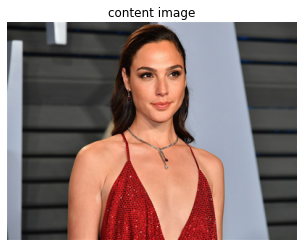

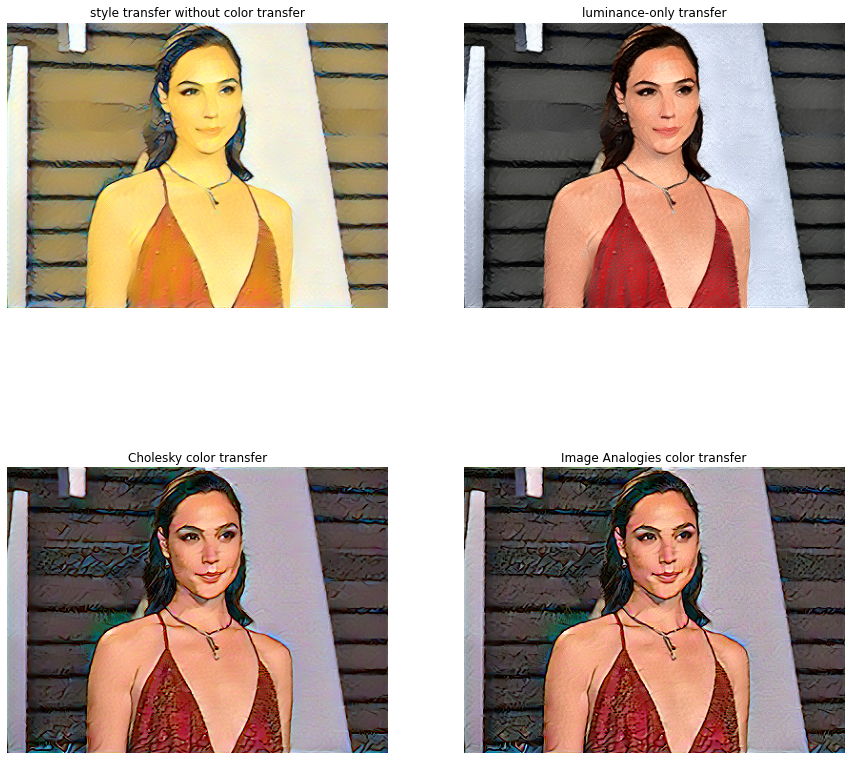

In [31]:
plt.imshow(content_image)
plt.title('content image')
plt.axis('off')
fig, ax = plt.subplots(nrows=2, ncols=2, figsize = [15, 15])
ax[0][0].imshow(gen0)
ax[0][0].set_title('style transfer without color transfer')
ax[0][0].axis('off')
ax[0][1].imshow(gen1)
ax[0][1].set_title('luminance-only transfer')
ax[0][1].axis('off')
ax[1][0].imshow(gen2)
ax[1][0].set_title('Cholesky color transfer')
ax[1][0].axis('off')
ax[1][1].imshow(gen3)
ax[1][1].set_title('Image Analogies color transfer')
ax[1][1].axis('off')